In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn pandas

Note: you may need to restart the kernel to use updated packages.


### Task - A

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
binary_dataset = pd.read_csv("train_all_tasks.csv", usecols=['text', 'label_sexist'])
print(binary_dataset.head())

                                                text label_sexist
0              Damn, this writing was pretty chaotic   not sexist
1  Yeah, and apparently a bunch of misogynistic v...   not sexist
2       How the FUCK is this woman still an MP!!!???   not sexist
3  Understand. Know you're right. At same time I ...   not sexist
4     Surprized they didn't stop and rape some women   not sexist


In [5]:
print(binary_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB
None


In [6]:
print(binary_dataset.describe())

                                         text label_sexist
count                                   14000        14000
unique                                  14000            2
top     Damn, this writing was pretty chaotic   not sexist
freq                                        1        10602


In [7]:
print(binary_dataset['label_sexist'].unique())

['not sexist' 'sexist']


### Encoding label_sexist column | not_sexist : 0 | sexist : 1

In [9]:
binary_dataset['label_sexist'] = binary_dataset['label_sexist'].map({'not sexist': 0, 'sexist': 1})
print(binary_dataset)

                                                    text  label_sexist
0                  Damn, this writing was pretty chaotic             0
1      Yeah, and apparently a bunch of misogynistic v...             0
2           How the FUCK is this woman still an MP!!!???             0
3      Understand. Know you're right. At same time I ...             0
4         Surprized they didn't stop and rape some women             0
...                                                  ...           ...
13995  complexes like the 'nice chicks' that go after...             1
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...             0
13997  Lol I imagine there would be simps that are li...             0
13998  It's not, the girls I go on dates with don't k...             0
13999  How can he be an incel? He does have a girlfri...             0

[14000 rows x 2 columns]


### Using wordcloud to visualize which words are associated with which class

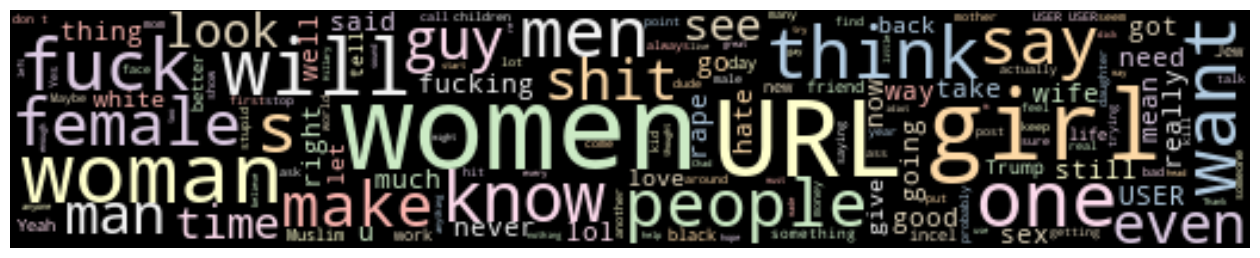

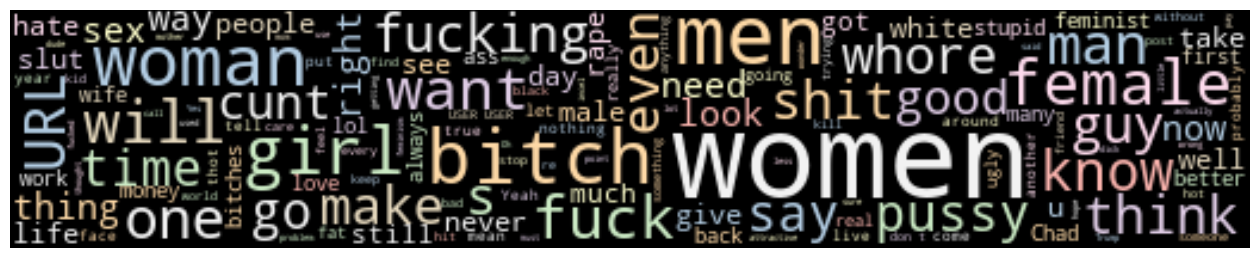

In [10]:
# Dropping all the sexist rows and convert the dataframe to a string
def convert_df_to_str(df, col_to_drop, row_label_to_drop, string_col):
    new_df = df[df[col_to_drop] == row_label_to_drop]
    new_df = new_df.drop(columns=[col_to_drop])
    new_df = ' '.join(new_df[string_col])
    return new_df

not_sexist_rows = convert_df_to_str(binary_dataset, 'label_sexist', 0, 'text')
sexist_rows = convert_df_to_str(binary_dataset, 'label_sexist', 1, 'text')

not_sexist_cloud = WordCloud(width =520, height =100, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(not_sexist_rows)
plt.figure(figsize=(16,10))
plt.imshow(not_sexist_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

sexist_cloud = WordCloud(width =520, height =100, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(sexist_rows)
plt.figure(figsize=(16,10))
plt.imshow(sexist_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

### Balancing the dataset using Oversampling, Undersampling, SMOTE

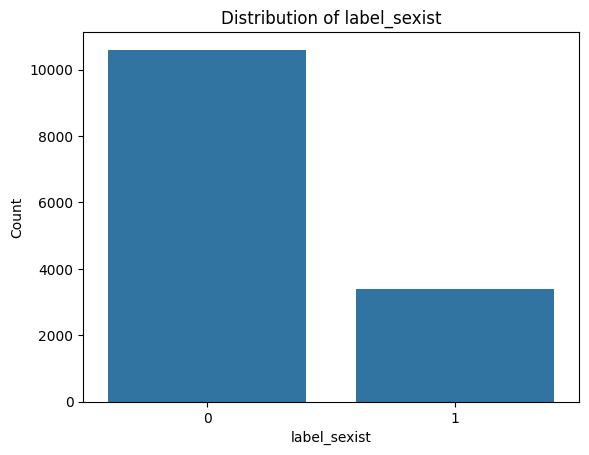

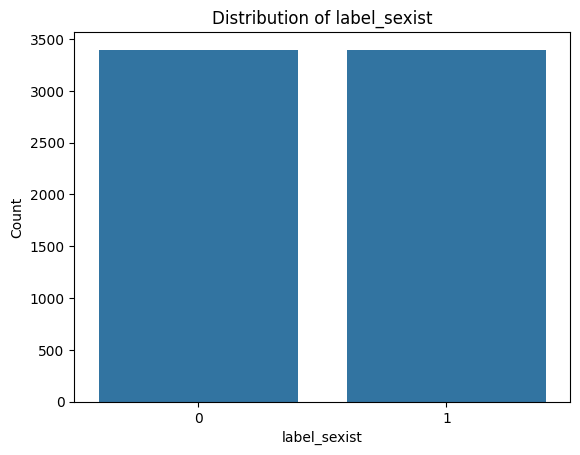

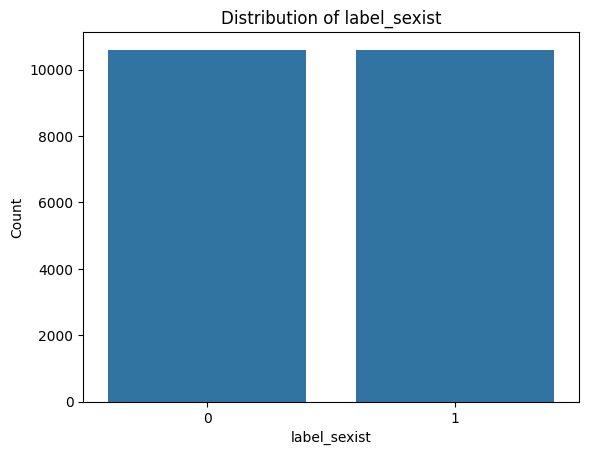

In [13]:
def sampler(df, target_variable, type):
    if type == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = RandomOverSampler(random_state=42)

    X_resampled, y_resampled = sampler.fit_resample(df.drop(columns=[target_variable]), df[target_variable])
    return pd.concat([X_resampled, y_resampled.rename('label_sexist')], axis=1)

binary_dataset_undersampled = sampler(binary_dataset, 'label_sexist', 'undersample')
binary_dataset_oversampled = sampler(binary_dataset, 'label_sexist', 'oversample')

target_variable = "label_sexist"
dataframes = [binary_dataset, binary_dataset_undersampled, binary_dataset_oversampled]
for i in range(len(dataframes)):
    sns.countplot(data=dataframes[i], x=target_variable)
    
    # Add Labels
    plt.xlabel(target_variable)
    plt.ylabel('Count')
    plt.title(f'Distribution of {target_variable}')
    
    plt.savefig("class_distribution.png")
    plt.show()

### Tokenzing and using Glove Embedding

                                                    text  label_sexist
0                  Damn, this writing was pretty chaotic             0
1      Yeah, and apparently a bunch of misogynistic v...             0
2           How the FUCK is this woman still an MP!!!???             0
3      Understand. Know you're right. At same time I ...             0
4         Surprized they didn't stop and rape some women             0
...                                                  ...           ...
13995  complexes like the 'nice chicks' that go after...             1
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...             0
13997  Lol I imagine there would be simps that are li...             0
13998  It's not, the girls I go on dates with don't k...             0
13999  How can he be an incel? He does have a girlfri...             0

[14000 rows x 2 columns]
Row with maximum length:
text            Thought: God took on flesh by being born to a ...
label_sexist                   